In [1]:
import os
def change_to_code_dir():
    current_dir = os.getcwd()
    if os.path.basename(current_dir) == "p2ch15":
        parent_dir = os.path.dirname(current_dir)
        os.chdir(parent_dir)    
change_to_code_dir()

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from p2ch15.dsets import getCandidateInfoList, LunaDataset

from p2ch15.utils import get_sam_model
from PIL import Image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
candidateInfo_list = getCandidateInfoList(require_on_disk=True)
print(len(candidateInfo_list))
positiveInfo_list = [x for x in candidateInfo_list if x[0]]
diameter_list = [x[1] for x in positiveInfo_list]

56938


In [13]:
dataset = LunaDataset(sortby_str="label_and_size")
print(len(dataset))
ct_slice, nodule_class, series_uid, center_irc = dataset[3]

2025-02-19 13:06:10,700 INFO     pid:76865 p2ch15.dsets:192:__init__ <p2ch15.dsets.LunaDataset object at 0x314494d40>: 56938 training samples


56938


In [14]:
ct_slice.shape

torch.Size([512, 512])

In [15]:
ct_slice

tensor([[-1000., -1000., -1000.,  ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000.,  ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000.,  ..., -1000., -1000., -1000.],
        ...,
        [-1000., -1000., -1000.,  ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000.,  ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000.,  ..., -1000., -1000., -1000.]])

In [16]:
center_irc

tensor([101, 234, 158])

tensor([101, 234, 158])


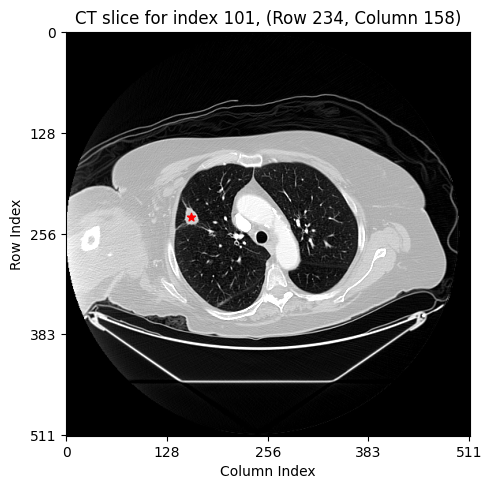

In [17]:
def add_point(ax, point, marker='*', color='red'):
    ax.scatter(point[2], point[1], marker=marker, color=color)

def plot_single_slice(tensor, point=None):
    """
    Plots a single slice from a 3D PyTorch tensor with shape (1, 512, 512).
    Optionally draws a point if coordinates are provided.
    Parameters:
    - tensor: 3D PyTorch tensor to plot, expected shape (1, 512, 512).
    - point: Tuple of (x, y) coordinates to draw a point on the plot.
    """
    clim = (-1000.0, 300)  # Define color limits
    # Convert the tensor to a NumPy array and extract the single slice
    slice_2d = tensor[:, :].cpu().numpy()
    # Create a plot
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(slice_2d, cmap='gray', clim=clim, origin="upper")
    # Set x and y ticks to integer values
    ax.set_xticks(np.round(np.linspace(0, slice_2d.shape[1] - 1, 5)).astype(int))
    ax.set_yticks(np.round(np.linspace(0, slice_2d.shape[0] - 1, 5)).astype(int))
    ax.set_xlabel('Column Index')
    ax.set_ylabel('Row Index')
    ax.set_title(f"CT slice for index {center_irc[0]}, (Row {center_irc[1]}, Column {center_irc[2]})")
    if point is not None:
        add_point(plt.gca(), point, marker='*', color='red')

    # Show the plot
    plt.tight_layout()
    plt.show()

print(center_irc)
plot_single_slice(ct_slice, center_irc)

In [40]:
from segment_anything import SamPredictor, sam_model_registry
model_config, model_weights_path = get_sam_model()

sam = sam_model_registry[model_config](checkpoint=model_weights_path)
sam.to(device)
predictor = SamPredictor(sam)

/Users/howardhuang/Documents/Mycode/DeepLearningWithPytorch-SecondEdition/.venv/lib/python3.12/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experim

In [41]:
rgb_ct_slice = ct_slice.repeat(3, 1, 1)
rgb_ct_slice.shape

torch.Size([3, 512, 512])

In [42]:
def normalize_tensor(tensor):
    """
    Normalize a tensor to a specified range.
    Parameters:
    - tensor (torch.Tensor): The input tensor to normalize.
    Returns:
    - torch.Tensor: The normalized tensor.
    """
    # Calculate the min and max values of the tensor
    min_val = tensor.min()
    max_val = tensor.max()
    # Normalize to [0, 1]
    normalized_tensor = (tensor - min_val) / (max_val - min_val)
    # If the tensor values are in [0, 1], scale them to [0, 255]
    scaled_tensor = (normalized_tensor * 255).clamp(0, 255).byte()

    return scaled_tensor
normalized_ct_slice = normalize_tensor(rgb_ct_slice)
normalized_ct_slice.shape

torch.Size([3, 512, 512])

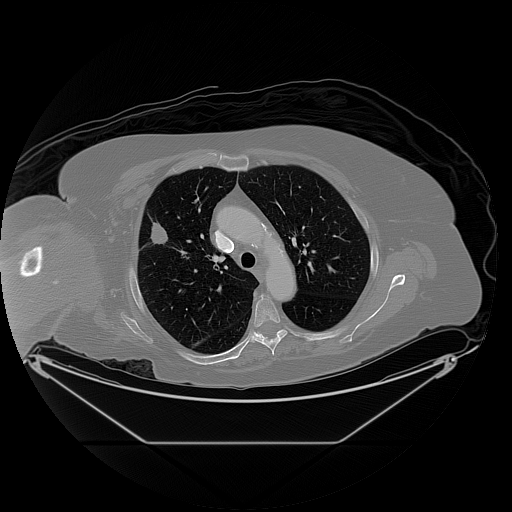

In [22]:
image = Image.fromarray(np.transpose(normalized_ct_slice.numpy(), (1, 2, 0)))
image

In [49]:
x, y = center_irc[2], center_irc[1]
input_points = np.array([[x, y]])

predictor.set_image(np.array(image))
masks, _, _ = predictor.predict(input_points, point_labels=np.array([1]), multimask_output=False)

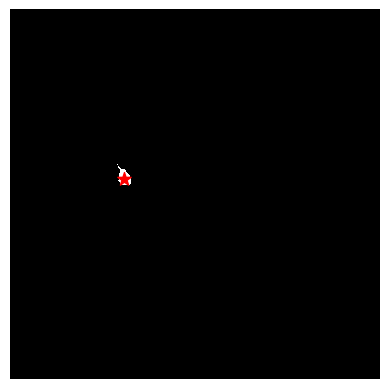

In [50]:
def plot_mask_with_point(mask, point):
    """
    Plots a boolean mask as a black and white image and overlays a point.
    Parameters:
    mask (numpy.ndarray): A 2D array of boolean values.
    point (list or tuple): A list or tuple containing the (x, y) coordinates of the point.
    Returns:
    None
    """
    # Convert the boolean mask to an integer array (True -> 1, False -> 0)
    int_mask = mask.astype(int)
    # Plot the mask
    plt.imshow(int_mask, cmap='gray', interpolation='nearest')
    
    # Overlay the point
    plt.scatter(point[0], point[1], color='red', s=100, marker='*')
    
    plt.axis('off')  # Turn off the axis
    plt.show()

plot_mask_with_point(masks[0], input_points[0])

/var/folders/n1/ygzk0n895x15grwb5rm1ld300000gn/T/ipykernel_76865/3258163420.py:20: UserWarning: linewidths is ignored by contourf
  plt.contourf(mask, levels=[0.5, 1], colors=[colors[i]], alpha=0.4, linewidths=1, hatches=['//'])


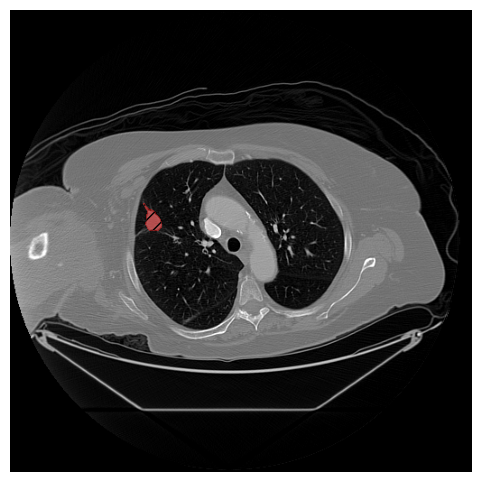

In [51]:
def plot_original_image_with_masks(image, masks):
    """
    Plots the image with masks overlaid in different colors.
    Args:
        image (PIL.Image): The original image.
        masks (list of np.ndarray): List of boolean masks.
    """
    # Convert image to numpy array
    image_np = np.array(image)
    # Create a figure and axis
    fig, ax = plt.subplots(1, figsize=(6, 6))
    ax.imshow(image_np, cmap='gray')
    # Generate a colormap
    cmap = plt.get_cmap('hsv')
    num_colors = len(masks)
    colors = [cmap(i / num_colors) for i in range(num_colors)]
    # Plot each mask
    for i, mask in enumerate(masks):
        # Find contours of the mask
        plt.contourf(mask, levels=[0.5, 1], colors=[colors[i]], alpha=0.4, linewidths=1, hatches=['//'])
    plt.axis('off')
    plt.show()
plot_original_image_with_masks(image, masks)